In [46]:

# Dataframe and Plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss



pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# LOAD the Dataset

In [47]:
# Load the files into a Pandas Dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
d = pd.read_csv('extra_data.csv')

In [48]:
# print the shape of the datasets.
print('Train data shape :', train.shape)
print('Test data shape :', test.shape)

Train data shape : (373, 12)
Test data shape : (558, 11)


In [49]:
d.USER_ID.nunique()

39

<BarContainer object of 13 artists>

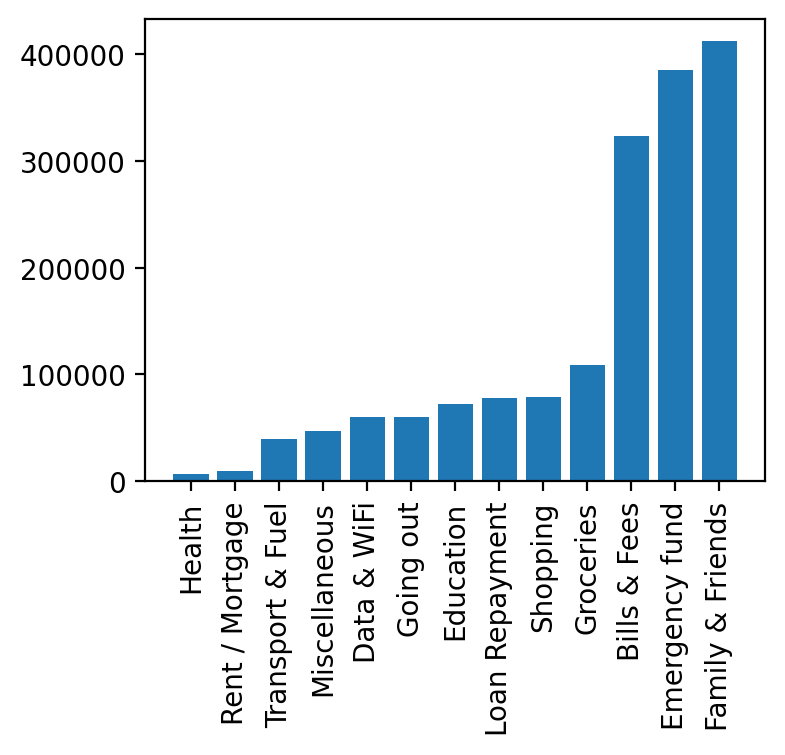

In [50]:
data = pd.pivot_table(train, values='PURCHASE_VALUE', index='MERCHANT_CATEGORIZED_AS', aggfunc='sum').reset_index(False)
data = data.sort_values('PURCHASE_VALUE')
# Bar graph of the purchase_value vs the target
plt.figure(dpi=200, figsize=(4,3))
plt.xticks(rotation=90)
plt.bar(data=data, x='MERCHANT_CATEGORIZED_AS', height='PURCHASE_VALUE')

In [51]:
labels_train = train['MERCHANT_CATEGORIZED_AS'].astype('category').cat.categories.tolist()
replace_map_train = {'MERCHANT_CATEGORIZED_AS' : {k: v for k,v in zip(labels_train,list(range(0,len(labels_train)+1)))}}
print("Train data: ", replace_map_train)

Train data:  {'MERCHANT_CATEGORIZED_AS': {'Bills & Fees': 0, 'Data & WiFi': 1, 'Education': 2, 'Emergency fund': 3, 'Family & Friends': 4, 'Going out': 5, 'Groceries': 6, 'Health': 7, 'Loan Repayment': 8, 'Miscellaneous': 9, 'Rent / Mortgage': 10, 'Shopping': 11, 'Transport & Fuel': 12}}


In [52]:
train_data_corr = train.copy()

In [53]:
# We can also use the .isnull() method to check for empty values
print('Missing values for Train:', train.isnull().sum())
print('')
print('Missing values for Test:', test.isnull().sum())

Missing values for Train: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

Missing values for Test: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 473
USER_GENDER                                5
USER_HOUSEHOLD                             0
USER_INCOME                        

In [54]:
train[train['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
35,2021-11-30 10:51:36.702996+00,IDEAL APPLIANCES,Bills & Fees,24995,2021-05-06 14:14:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_3xlptxy6
137,2021-11-30 10:52:38.553994+00,QUICK MART,Shopping,3298,2021-06-19 15:05:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_dhp3d403
280,2021-08-06 11:28:03.723042+00,EQUITY PAYBILL,Shopping,4000,2021-07-25 10:54:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qvgzrt0r
309,2021-11-30 10:52:38.553994+00,NAOMI WANJOHI,Family & Friends,1028,2021-05-13 14:28:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_u02b0hl6
312,2021-11-30 10:51:36.702996+00,POA,Data & WiFi,1500,2021-07-21 17:46:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_uvhgthza
361,2021-11-30 10:51:36.702996+00,MIRIAM MUNGAI,Family & Friends,1600,2021-06-11 18:25:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_yxz5etfz


In [55]:
test[test['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
124,2021-08-06 11:28:16.857538+00,ACCESS AFYA,1,2021-08-05 09:32:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_8oyhw5j0
138,2021-11-30 10:51:36.702996+00,PETER INDIMULI,1028,2021-04-08 12:07:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_9au0g3qv
374,2021-11-30 10:51:36.702996+00,MICHELLE RODROT,827,2021-07-22 13:36:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_p5ajidvp
395,2021-11-30 10:51:36.702996+00,DORCAS WANJOHI,2600,2021-06-07 14:05:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qd7dgqor
550,2021-11-30 10:52:38.553994+00,POA,1500,2021-05-22 19:11:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_zqi8lti6


In [56]:
train.USER_GENDER.value_counts()

Male      197
Female    170
Name: USER_GENDER, dtype: int64

In [57]:
test.USER_GENDER.value_counts()

Male      307
Female    246
Name: USER_GENDER, dtype: int64

In [58]:
train["USER_GENDER"] = train["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)
test["USER_GENDER"] = test["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)

In [59]:
# Impute the missing age entries with the median of that column
train_median_value = np.median(train['USER_AGE'].dropna())
train['USER_AGE'] = train['USER_AGE'].fillna(train_median_value)

test_median_value = np.median(test['USER_AGE'].dropna())
test['USER_AGE'] = test['USER_AGE'].fillna(test_median_value)

In [60]:
train["train"] = 1
test["train"] = 0

In [61]:
all_data = pd.concat([train, test])

In [62]:
all_data = pd.get_dummies(all_data, prefix_sep="_", columns=['MERCHANT_NAME'])

In [63]:
train = all_data[all_data["train"] == 1]
test = all_data[all_data["train"] == 0]

In [64]:
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (373, 452)
Test:  (558, 452)


In [65]:
train = train.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', 'Transaction_ID', "train"], axis=1)
test = test.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', "train", "MERCHANT_CATEGORIZED_AS"], axis=1)

In [66]:
# Based on our data set, this function converts boolean to binary entries
def create_binary_cols(content):
  if content == False:
    content = 0
  elif content == True:
    content = 1
  elif content == 'N':
    content = 0
  elif content == 'Y':
    content = 1
  elif content == 'Male':
    content = 0
  elif content == 'Female':
    content = 1
  return content

In [67]:
# Gender column convert:
train['USER_GENDER'] = train['USER_GENDER'].apply(create_binary_cols)
test['USER_GENDER'] = test['USER_GENDER'].apply(create_binary_cols)

# Is_purchase_paid_via_mpesa_send_money column convert:
train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)
test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)

In [68]:
#Separate the features from the target in the training data
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train["MERCHANT_CATEGORIZED_AS"]

In [69]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)

In [70]:
# from mlxtend.classifier import StackingClassifier
# from sklearn.model_selection import KFold
# from catboost import CatBoostClassifier, Pool
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RepeatedStratifiedKFold

# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# import lightgbm as lgb
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.svm import SVC

# kf = KFold(n_splits=5,random_state=42,shuffle=True)
# for i, (train_index, valid_index) in enumerate(kf.split(X_resampled,y_resampled)):

#     X_train, y_train = X_resampled.iloc[train_index], y_resampled.iloc[train_index]
#     X_val, y_val = X_resampled.iloc[valid_index], y_resampled.iloc[valid_index]


#     m =OneVsRestClassifier(StackingClassifier(
#         classifiers=[
#             LogisticRegression(),
#     CatBoostClassifier(
#          iterations=150,
#         #depth=11,
#         #use_best_model =True,
#         verbose =0,

#         task_type="GPU",
#             learning_rate=0.1,
#         early_stopping_rounds= 100
#     )    ],
#         use_probas=True,
#         meta_classifier=LogisticRegression()
#     ))





#     m.fit(X_train, y_train),
#     preds = m.predict_proba(X_val)
#     loss+=log_loss(y_val, preds)
#     print(f'log_loss: {log_loss(y_val, preds)}')
# print(loss/5)

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=101)

In [72]:
# Creating a Decision tree classifier
model_dtree = DecisionTreeClassifier(max_depth=5, random_state=101,
                                     max_features = None, min_samples_leaf=8)

# Training the model on the training dataset
model_dtree.fit(X_train, y_train)

# Predict
y_pred = model_dtree.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))

ACCURACY OF THE MODEL:  0.4803921568627451
                  precision    recall  f1-score   support

    Bills & Fees       0.00      0.00      0.00        11
     Data & WiFi       1.00      0.43      0.60         7
       Education       1.00      1.00      1.00         7
  Emergency fund       1.00      0.25      0.40        12
Family & Friends       0.69      0.82      0.75        11
       Going out       0.00      0.00      0.00         5
       Groceries       0.30      0.60      0.40         5
          Health       0.15      1.00      0.26         5
  Loan Repayment       0.44      0.80      0.57         5
   Miscellaneous       1.00      0.33      0.50         6
 Rent / Mortgage       1.00      0.90      0.95        10
        Shopping       0.50      0.18      0.27        11
Transport & Fuel       1.00      0.29      0.44         7

        accuracy                           0.48       102
       macro avg       0.62      0.51      0.47       102
    weighted avg       0.65

In [73]:
from sklearn.ensemble import RandomForestClassifier

# Creating a RF classifier
clf = RandomForestClassifier()

# Training the model on the training dataset
clf.fit(X_train, y_train)

# Performing predictions on the test dataset
y_pred = clf.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))


ACCURACY OF THE MODEL:  0.8529411764705882
                  precision    recall  f1-score   support

    Bills & Fees       0.80      0.36      0.50        11
     Data & WiFi       0.86      0.86      0.86         7
       Education       1.00      1.00      1.00         7
  Emergency fund       0.73      0.92      0.81        12
Family & Friends       0.83      0.91      0.87        11
       Going out       0.83      1.00      0.91         5
       Groceries       0.67      0.80      0.73         5
          Health       1.00      1.00      1.00         5
  Loan Repayment       1.00      1.00      1.00         5
   Miscellaneous       0.71      0.83      0.77         6
 Rent / Mortgage       1.00      1.00      1.00        10
        Shopping       0.85      1.00      0.92        11
Transport & Fuel       1.00      0.57      0.73         7

        accuracy                           0.85       102
       macro avg       0.87      0.87      0.85       102
    weighted avg       0.86

In [74]:
train_data_corr.replace(replace_map_train, inplace=True)

In [75]:
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train_data_corr["MERCHANT_CATEGORIZED_AS"]

In [76]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=101)

In [78]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [79]:
expected_y  = y_val
predicted_y = model.predict(X_val)

In [80]:
print(classification_report(expected_y, predicted_y))
print(accuracy_score(y_val, predicted_y))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       0.91      0.83      0.87        12
           4       0.79      1.00      0.88        11
           5       0.67      0.80      0.73         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.62      0.83      0.71         6
          10       1.00      0.90      0.95        10
          11       0.91      0.91      0.91        11
          12       0.86      0.86      0.86         7

    accuracy                           0.86       102
   macro avg       0.88      0.87      0.87       102
weighted avg       0.87      0.86      0.86       102

0.8627450980392157


<Axes: xlabel='MERCHANT_CATEGORIZED_AS'>

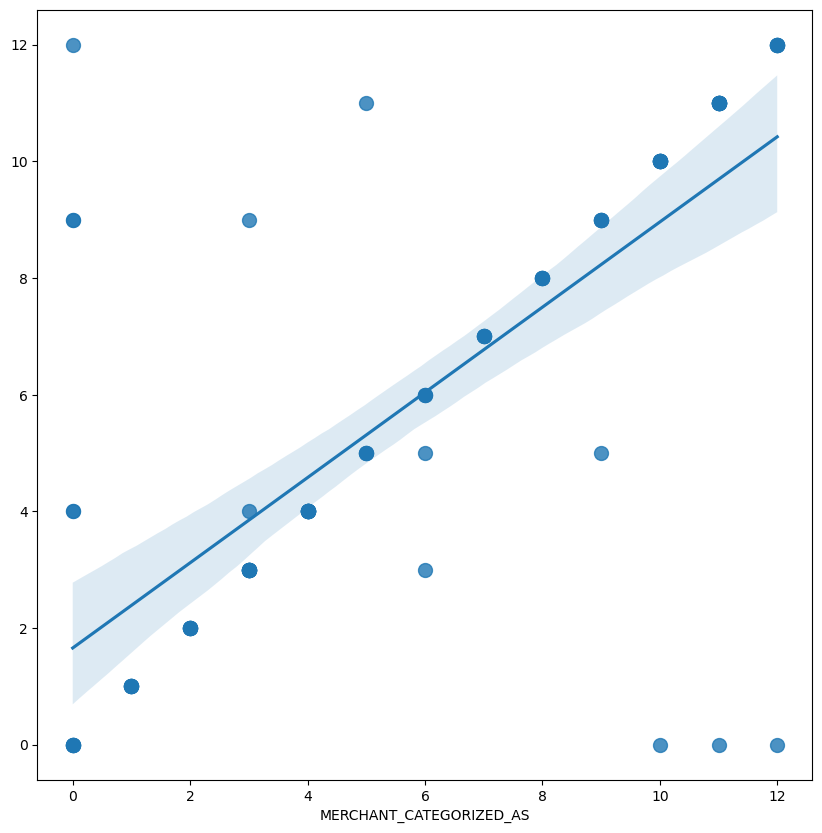

In [81]:
plt.figure(figsize=(10,10))
sns.regplot(x=expected_y, y=predicted_y, fit_reg=True, scatter_kws={"s": 100})

In [82]:
# Get the predicted result for the test Data
predictions = clf.predict(test.drop("Transaction_ID", axis=1))

In [83]:
preds = clf.predict_proba(test.drop("Transaction_ID" , axis=1))
preds_df = pd.DataFrame(preds, columns=labels_train)
preds_df = pd.concat(objs=[test["Transaction_ID"], preds_df], axis="columns")

In [84]:
test["predictions"] = predictions

In [85]:
test[["Transaction_ID",  "predictions"]].head()

,Transaction_ID,predictions
0,ID_00x9h2yx,Family & Friends
1,ID_01db594f,Going out
2,ID_07pm99no,Miscellaneous
3,ID_09jryhkd,Going out
4,ID_0ccv924c,Rent / Mortgage


In [86]:
test[["Transaction_ID",  "predictions"]]["predictions"].nunique()

12

In [87]:
sub = test[["Transaction_ID",  "predictions"]]

In [88]:
preds_df.head()

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0.07,0.01,0.04,0.19,0.43,0.00,0.02,0.0,0.08,0.00,0.00,0.16,0.00
1,ID_01db594f,0.02,0.00,0.00,0.00,0.00,0.97,0.01,0.0,0.00,0.00,0.00,0.00,0.00
2,ID_07pm99no,0.00,0.00,0.00,0.00,0.00,0.16,0.02,0.0,0.00,0.59,0.00,0.04,0.19
3,ID_09jryhkd,0.01,0.04,0.00,0.00,0.07,0.63,0.00,0.0,0.00,0.24,0.00,0.00,0.01
4,ID_0ccv924c,0.07,0.14,0.04,0.13,0.08,0.06,0.00,0.0,0.03,0.00,0.36,0.09,0.00


In [89]:
sub = pd.get_dummies(sub, columns=['predictions'])

# # remove the prefix
sub.columns = sub.columns.str.replace('predictions_','')

In [90]:
sub.head(1)

,Transaction_ID,Bills & Fees,Data & WiFi,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0,0,0,1,0,0,0,0,0,0,0,0
